In [1]:
# Run only once
%cd ..

/Users/goloshch/QUBO_Solver


### 2-SAT Solver and Posix planted solutions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.qubo_solver.utils import *
from src.qubo_solver.sat_solver import *
from src.qubo_solver.plot import *

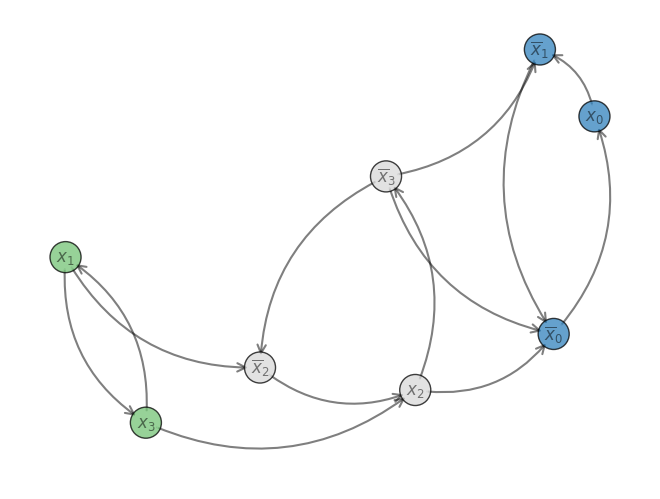

In [3]:
if __name__ == "__main__":
    adjacency_list = {
        0: set([1]),
        1: set([2]),
        2: set([0]),
        3: set([4,7]),
        4: set([5]),
        5: set([0,6]),
        6: set([0,2,4]),
        7: set([3,5])
    }

    low_link = SCC(adjacency_list).get_scc()
    draw_2sat(adjacency_list, low_link)

0 0 0


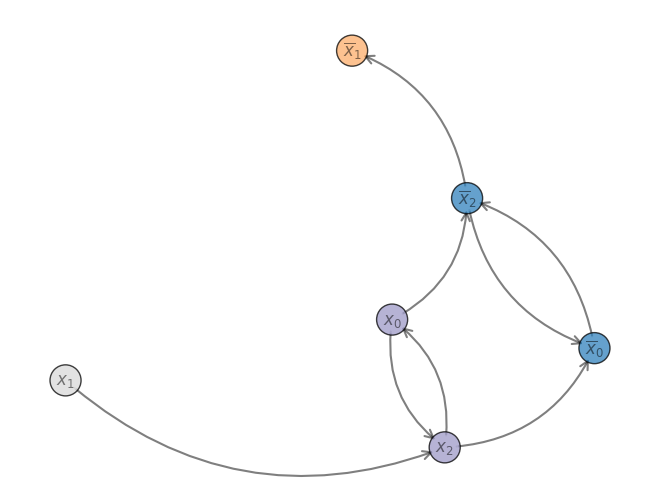

In [4]:
expression = [2, 5, 0, 5, 0, 4, 1, 4]
adjacency_list = graph_from_2sat(expression)
low_link = SCC(adjacency_list).get_scc()
solution = get_solution(adjacency_list, low_link)
print(*solution)
draw_2sat(adjacency_list, low_link)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 

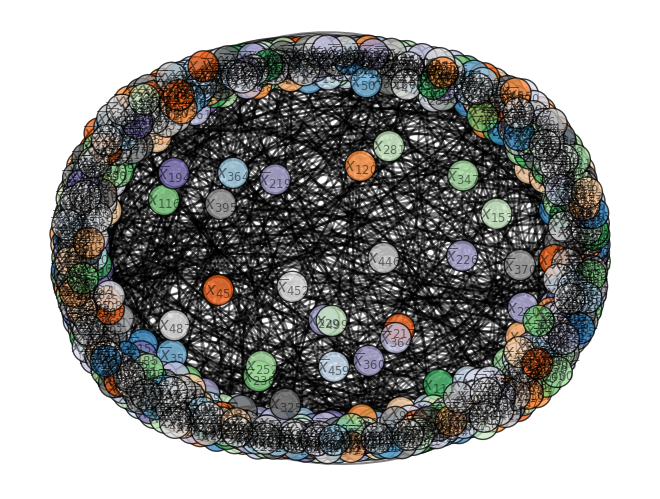

In [7]:
while True:
    expression = generate_expression(510, 405)
    adjacency_list = graph_from_2sat(expression)
    low_link = SCC(adjacency_list).get_scc()

    try:
        solution = get_solution(adjacency_list, low_link)
        draw_2sat(
            adjacency_list, 
            low_link,
            seed=121343
            )
        print(*solution)
        break
    except ValueError:
        pass

In [31]:
expression = generate_expression(int(1e5), int(1e5))
adjacency_list = graph_from_2sat(expression)
low_link = SCC(adjacency_list).get_scc()
solution = get_solution(adjacency_list, low_link)

In [52]:
n = int(1e2)
iters = int(4e2)
probs = [1.0]
ms = range(1, 2*n+2, n//10)

for m in ms[1:]:
    t = 0
    for _ in range(iters):
        expression = generate_expression(n, m)
        adjacency_list = graph_from_2sat(expression)
        low_link = SCC(adjacency_list).get_scc()
        try:
            solution = get_solution(adjacency_list, low_link)
            t += 1
        except ValueError:
            pass 
    probs.append(t/iters)

Text(0.5, 1.0, 'n=100')

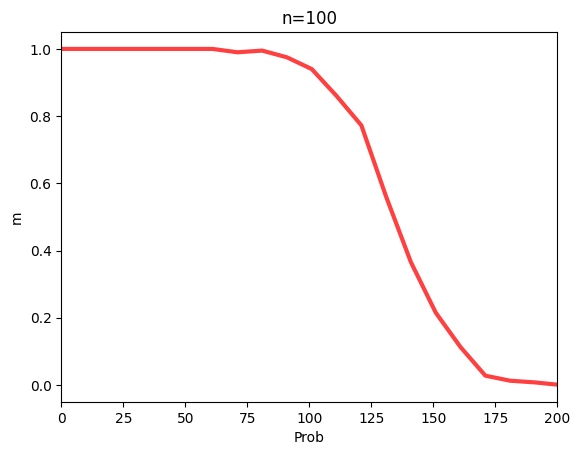

In [53]:

# probs += [0.0]
plt.plot(ms, probs, linewidth=3, color='red', alpha=0.75)
plt.xlim(0, 2*n)
plt.xlabel('Prob')
plt.ylabel("m")
plt.title("n=100")
# plt.ylim(0.0, 1.0)

### Gradient-based planting

In [250]:
import torch
import matplotlib.pyplot as plt

In [219]:
def find_Q(x, reg, iters=int(1e3)):
    n = x.shape[0]
    Q = torch.rand(size=(n, n), requires_grad=True)
    W = torch.rand(size=(n, n))
    W = reg * W / torch.norm(W)
    optimiser = torch.optim.Adam([Q])
    logs = []

    for _ in range(iters):
        loss = torch.dot(x, Q @ x) + torch.norm(Q@W)**2
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        logs.append(loss.detach().numpy())
            
    return Q.detach(), logs


def gen_all_binary_vectors(n: int) -> torch.Tensor:
    return ((torch.arange(2**n).unsqueeze(1) >> torch.arange(n-1, -1, -1)) & 1).float()


def is_solution(x: torch.Tensor, Q: torch.Tensor) -> bool:
    n = len(x)
    strings = gen_all_binary_vectors(n).T
    answers = torch.sum(strings * (Q @ strings), axis=0)
    
    return torch.dot(x, Q @ x) <= torch.min(answers)
    

tensor(23.9683)


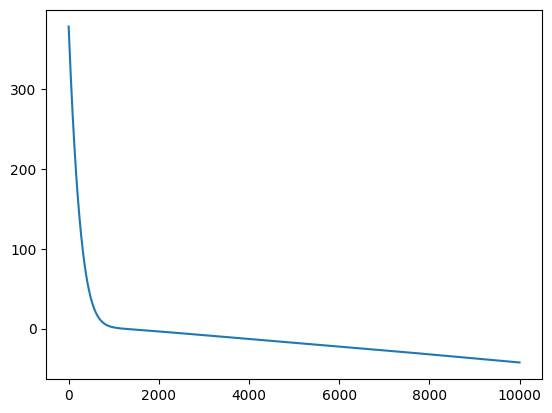

In [221]:
n = 10
reg = 1.0

Q, logs = find_Q(x, reg=4, iters=int(1e4))
print(torch.norm(Q))
plt.plot(logs)

### Chook testing

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from chook.planters.wishart_planting import generate_problem

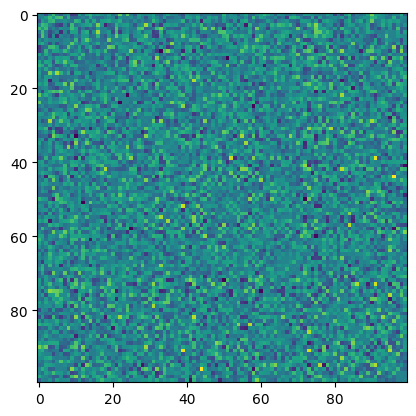

In [47]:
alpha = 0.3
n, m = 100, int(alpha*n)
Q = generate_problem(n, M=m)
plt.imshow(Q)

In [51]:
%time [generate_problem(int(5e2), M=int(1e2)) for _ in range(int(1e3))]

CPU times: user 13 s, sys: 2.36 s, total: 15.3 s
Wall time: 12.6 s


[array([[ 0.        , -0.01221827, -0.0223982 , ...,  0.01929675,
          0.00321707,  0.02353437],
        [-0.01221827,  0.        ,  0.00341381, ...,  0.002584  ,
         -0.00134103,  0.00986561],
        [-0.0223982 ,  0.00341381,  0.        , ...,  0.03792514,
         -0.03097596,  0.00445637],
        ...,
        [ 0.01929675,  0.002584  ,  0.03792514, ...,  0.        ,
          0.01818308,  0.01769304],
        [ 0.00321707, -0.00134103, -0.03097596, ...,  0.01818308,
          0.        , -0.01397719],
        [ 0.02353437,  0.00986561,  0.00445637, ...,  0.01769304,
         -0.01397719,  0.        ]]),
 array([[ 0.        ,  0.01119899,  0.00599244, ...,  0.01983599,
         -0.039086  ,  0.01875237],
        [ 0.01119899,  0.        ,  0.01042393, ..., -0.04012515,
         -0.00602949, -0.00718229],
        [ 0.00599244,  0.01042393,  0.        , ...,  0.00039686,
         -0.00789067, -0.00451518],
        ...,
        [ 0.01983599, -0.04012515,  0.00039686, ...,  

In [56]:
a = [[1,2], [3,4]]

for i, (s, t) in enumerate(a):
    print(i,s, t)

0 1 2
1 3 4


In [69]:
from collections import deque
from copy import copy, deepcopy
from typing import List

"""
We can check if the board is valid after 
adding an element by checking that
number of unfilled elements in current row/col/box
is less or equal to number of possible elements 
in this row/col/box

I can choose elements with most constraints and fill them first. 
"""
class Solution:
    def get_valid(self, board, config, pos):
        i, j = pos
        valid_row = set([str(i) for i in range(1,10)])
        valid_col = set([str(i) for i in range(1,10)])
        valid_box = set([str(i) for i in range(1,10)])
        unfilled_row = 9
        unfilled_col = 9
        unfilled_box = 9

        # Check rows and columns in starting board
        for k in range(9):
            if board[i][k].isdigit():
                valid_row -= {board[i][k]}
                unfilled_row -= 1
            if board[k][j].isdigit():
                valid_col -= {board[k][j]}
                unfilled_col -= 1
        
        # Check 3x3 box in starting board
        for k in range(3*(i//3), 3*(i//3)+3):
            for m in range(3*(j//3), 3*(j//3)+3):
                if board[k][m].isdigit():
                    valid_box -= {board[k][m]}
                    unfilled_box -= 1

        # Check rows,cols and 3x3 bon in configs
        for (num, k, m) in config:
            if k==i:
                valid_row -= {num}
                unfilled_row -= 1
            elif m==j:
                valid_col -= {num}
                unfilled_col -= 1
            elif (k//3 == i//3 and m//3 == j//3):
                valid_box -= {num}
                unfilled_box -= 1

        if ((len(valid_row) < unfilled_row) or
            (len(valid_col) < unfilled_col) or
            (len(valid_box) < unfilled_box)):
            return {}

        # print(valid_row, unfilled_row)
        # print(valid_col, unfilled_col)
        # print(valid_box, unfilled_box)
        return valid_row & valid_col & valid_box


    def find_next(self, board, pos):
        i, j = pos
        if 9*i+j > 80:
            return(9,9)
        elif j==9:
            i += 1
            j = 0

        for m in range(j, 9):
            if board[i][m] == '.':
                return (i,m)

        for k in range(i+1,9):
            for m in range(9):
                if board[k][m] == '.':
                    return (k,m)
        return (9,9)
    

    def config_to_board(self, board, config):
        new_board = [[board[i][j] for j in range(9)] for i in range(9)]
        for num, i, j in config:
            new_board[i][j] = num
        return new_board


    def solveSudoku(self, board: List[List[str]]) -> None:
        configs = deque()
        configs.appendleft([])
        i, j = 0, 0

        while True:
            print(len(configs), configs[-1])
            i, j = self.find_next(board,(i,j))
            if (i,j)==(9,9):
                config = configs.pop()
                return self.config_to_board(board, config)
            
            n = len(configs)
            for _ in range(n):
                config = configs.pop()
                valid = self.get_valid(board, config, (i,j))
                for num in valid:
                    configs.appendleft(config + [(num,i,j)])
            j += 1

In [86]:
from collections import deque
from copy import copy, deepcopy
"""
We can check if the board is valid after 
adding an element by checking that
number of unfilled elements in current row/col/box
is less or equal to number of possible elements 
in this row/col/box
"""
class Solution:
    def get_valid(self, board, pos):
        i, j = pos
        valid = set(map(str, range(1, 10)))
        for k in range(9):
            valid -= {board[i][k]}
            valid -= {board[k][j]}

        for k in range(3*(i//3), 3*(i//3)+3):
            for m in range(3*(j//3), 3*(j//3)+3):
                valid -= {board[k][m]}

        return valid


    def solve(self, board):
        for i in range(9):
            for j in range(9):
                if board[i][j] == '.':
                    valid = self.get_valid(board, (i,j))
                    for num in valid:
                        board[i][j] = num
                        if self.solve(board):
                            return True
                        board[i][j] = '.'
                    return False
        return True

    def solveSudoku(self, board: List[List[str]]) -> None:
       self.solve(board)

In [119]:
from heapq import heapify, heappop

n = 10
dist = [float('inf')] * n
dist[0] = 0

unvisited = [(dist[i], i) for i in range(n)]
heapify(unvisited)
unvisited_set = set(range(n))
unvisited

[(0, 0),
 (inf, 1),
 (inf, 2),
 (inf, 3),
 (inf, 4),
 (inf, 5),
 (inf, 6),
 (inf, 7),
 (inf, 8),
 (inf, 9)]

In [108]:
s = "alice,20,800,mtv"
[float('inf'), float('inf')] > [float('inf'), 0]

True

In [113]:
import heapq
nums = list(range(20, 10, -1))
heapq.heapify(nums)
nums

[11, 12, 14, 13, 16, 15, 18, 20, 17, 19]

In [92]:
board1 = [
         ["5","3",".",".","7",".",".",".","."],
         ["6",".",".","1","9","5",".",".","."],
         [".","9","8",".",".",".",".","6","."],
         ["8",".",".",".","6",".",".",".","3"],
         ["4",".",".","8",".","3",".",".","1"],
         ["7",".",".",".","2",".",".",".","6"],
         [".","6",".",".",".",".","2","8","."],
         [".",".",".","4","1","9",".",".","5"],
         [".",".",".",".","8",".",".","7","9"]
         ]

board2 = [
    [".",".",".",".",".",".",".",".","."],
    [".","9",".",".","1",".",".","3","."],
    [".",".","6",".","2",".","7",".","."],
    [".",".",".","3",".","4",".",".","."],
    ["2","1",".",".",".",".",".","9","8"],
    [".",".",".",".",".",".",".",".","."],
    [".",".","2","5",".","6","4",".","."],
    [".","8",".",".",".",".",".","1","."],
    [".",".",".",".",".",".",".",".","."]
    ]

sol = Solution()
sol.solveSudoku(board2)
# sol.get_valid(board2, [], (0,0))

In [93]:
board2

[['7', '2', '1', '8', '5', '3', '9', '4', '6'],
 ['4', '9', '5', '6', '1', '7', '8', '3', '2'],
 ['8', '3', '6', '4', '2', '9', '7', '5', '1'],
 ['9', '6', '7', '3', '8', '4', '1', '2', '5'],
 ['2', '1', '4', '7', '6', '5', '3', '9', '8'],
 ['3', '5', '8', '2', '9', '1', '6', '7', '4'],
 ['1', '7', '2', '5', '3', '6', '4', '8', '9'],
 ['6', '8', '3', '9', '4', '2', '5', '1', '7'],
 ['5', '4', '9', '1', '7', '8', '2', '6', '3']]

In [25]:
{str(i) for i in range(1,10)} - {'3','5','6','9','8'}

{'1', '2', '4', '7'}

In [1]:
import torch

In [5]:
torch.randint(low=0, high=2, size=(10,))

tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

In [19]:
torch.round(5*torch.rand(size=(10,))).type(torch.uint32)

AttributeError: module 'torch' has no attribute 'uint32'